# Face Multiclassifier Project
## Thomas More | AI-Frameworks
### Matthias Hefel

sort cropped faces, by x (left to right), first face is the first label. then save the images into folders with the responding label names
and then also a default folder, where you put all of the cropped faces (to do predictions on) 

face recognition with cv2
cv2.face.LBPHFFaceRecognizer_create()

find videos of youtube
opencv face recognitions

facenet (face recognition)
mtcnn

In [2]:
import pandas as pd


In [3]:
label_data = pd.read_csv('../data/labels/clean_data.csv', delimiter=",")
label_data['label_name'] = label_data['label_name'].apply(eval)

label_data.head()


,image,label_name
0,1,[senne]
1,2,"[youssef, akif]"
2,3,[seppe]
3,4,"[youssef, akif]"
4,5,[michiel]


In [4]:
import os
import cv2
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(label_data['label_name'])

label_map = dict(zip(label_data['image'].astype(str).str.zfill(4) + ".jpg", labels))

def load_images_and_labels(image_folder, label_map, size=(224, 224)):
    images = []
    image_labels = []
    for filename in os.listdir(image_folder):
        if filename in label_map:
            img_path = os.path.join(image_folder, filename)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            # img = cv2.resize(img, size)
            # img = img / 255.0  
            images.append(img)

            image_labels.append(label_map[filename])

    return np.array(images), np.array(image_labels)

images, labels = load_images_and_labels("../data/images/cleaned_images", label_map)

In [ ]:
def detect_faces(image, face_cascade):
    # gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(image, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    return faces

def extract_faces_from_images(images, labels, face_cascade):
    face_images = []
    face_labels = []

    for img, label in zip(images, labels):
        faces = detect_faces(img, face_cascade)
        for (x, y, w, h) in faces:
            face = img[y:y+h, x:x+w]  
            face = cv2.resize(face, (224, 224)) 
            face_images.append(face)
            face_labels.append(label)  

    return np.array(face_images), np.array(face_labels)

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml') # only does frontfaces, later increase for sideview aswell

face_images, face_labels = extract_faces_from_images(images, labels, face_cascade)

face_images = face_images[..., np.newaxis]
print("extracted faces:", face_images.shape)


extracted faces: (237, 224, 224, 1)


In [16]:
labels

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 1],
       [0, 0, 1, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [17]:
import matplotlib.pyplot as plt

def display_images(images, labels, class_names, num_images=9):
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(3, 3, i + 1) 
        plt.imshow(images[i], cmap="gray")
        plt.title(", ".join([class_names[j] for j, val in enumerate(labels[i]) if val == 1]))
        plt.axis('off') 
    plt.tight_layout()
    plt.show()



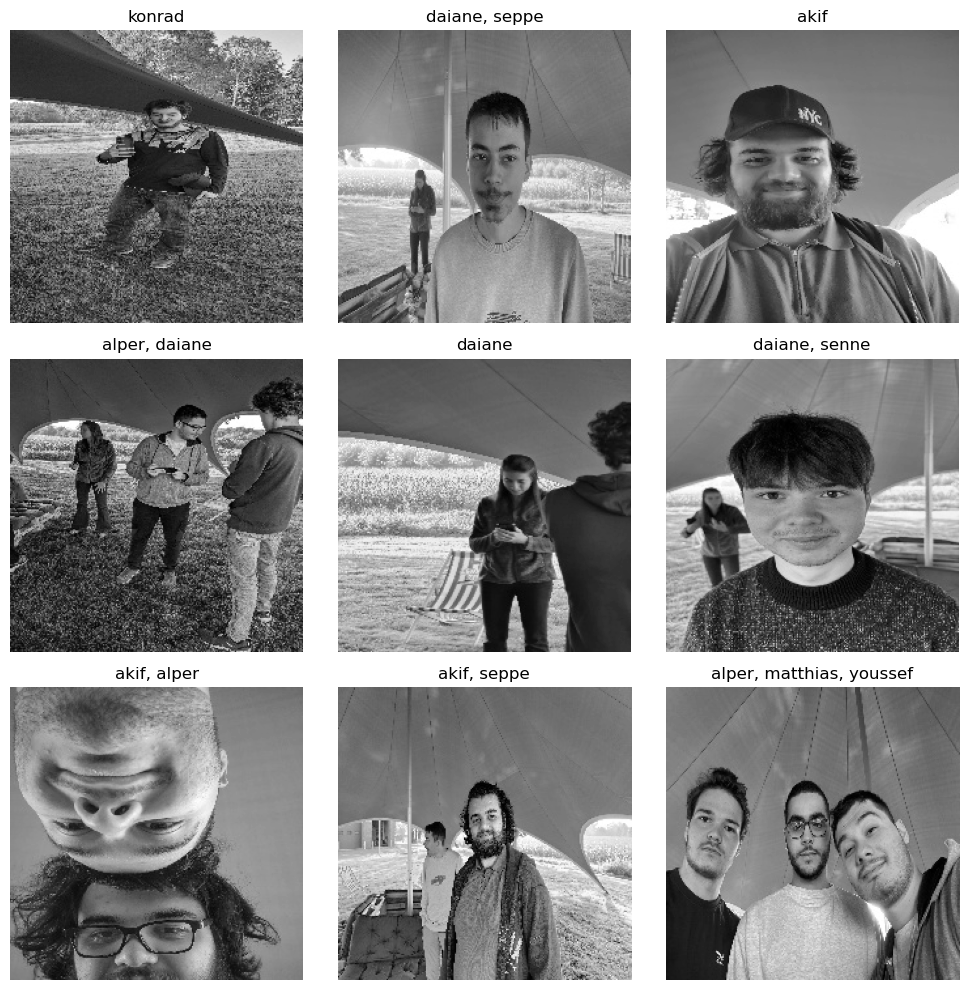

In [18]:
display_images(images, labels, mlb.classes_)


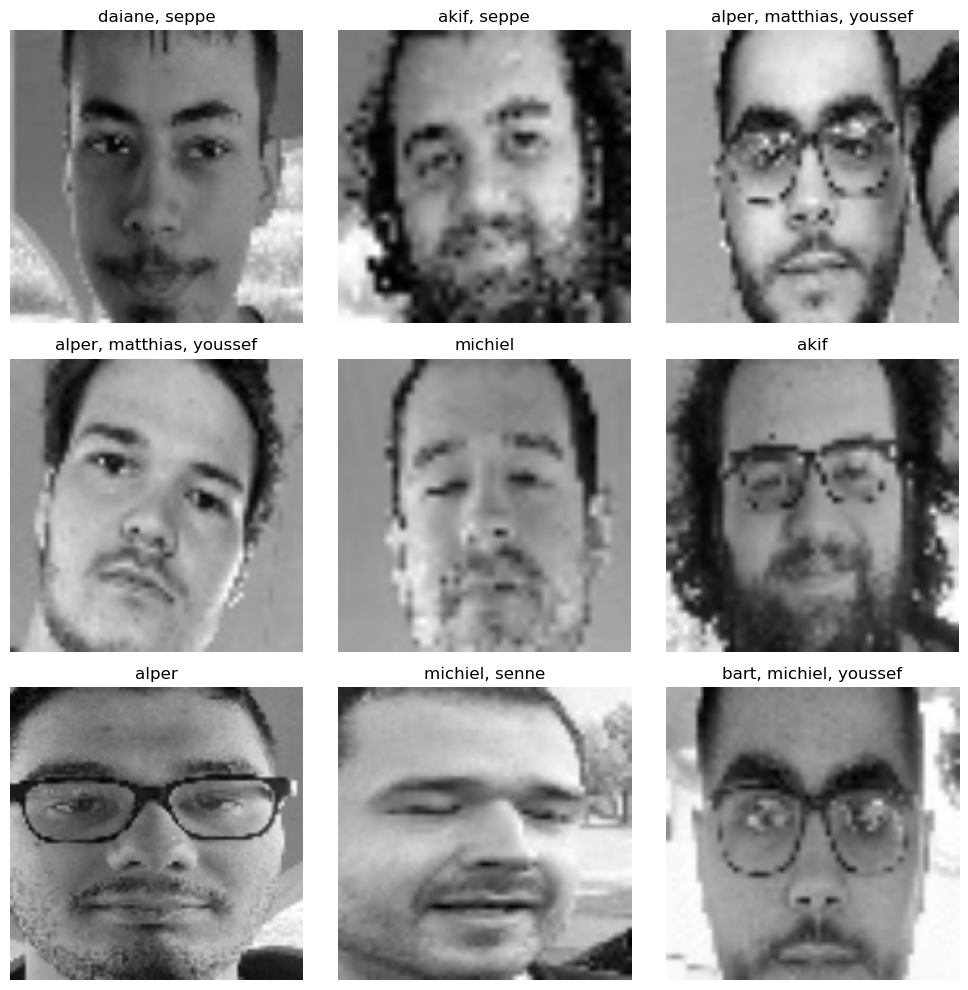

In [19]:
display_images(face_images, face_labels, mlb.classes_)


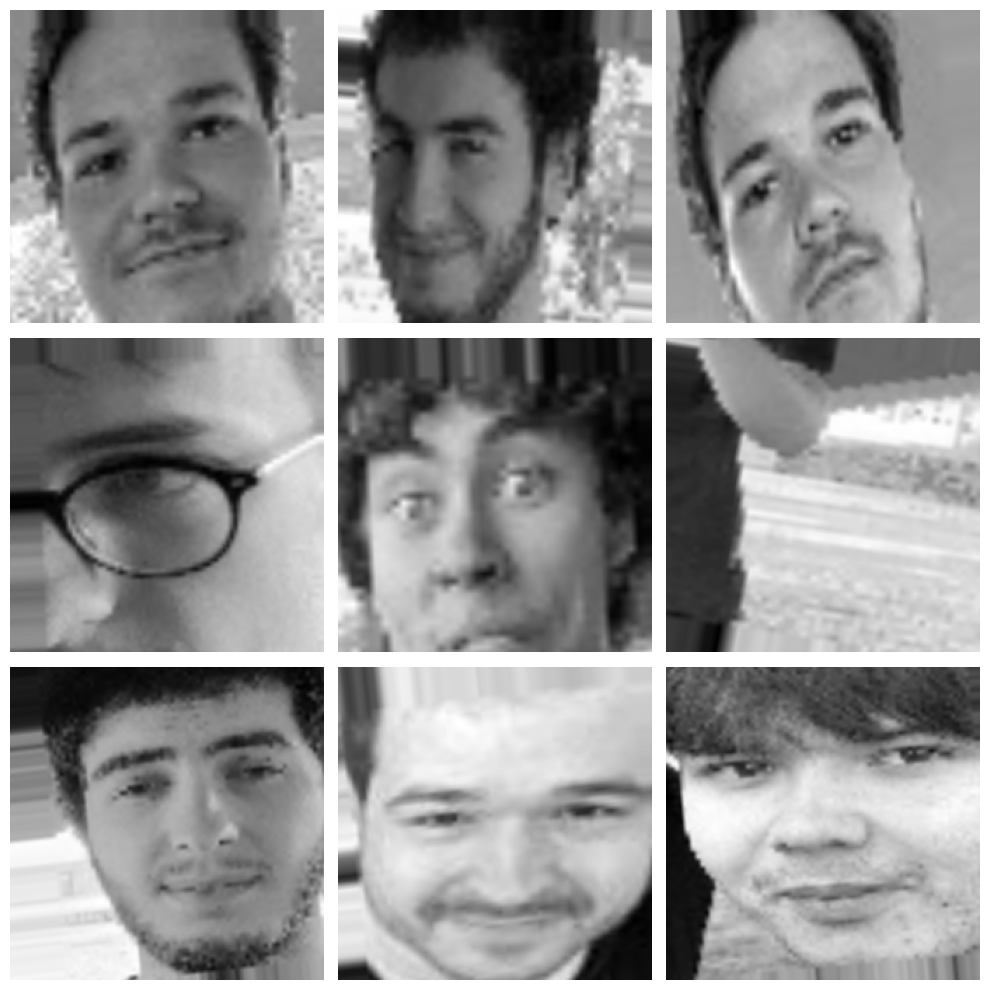

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

generated_images = datagen.flow(face_images, face_labels, batch_size=32)

import matplotlib.pyplot as plt

x_batch, y_batch = next(generated_images)

plt.figure(figsize=(10, 10))
for i in range(9): 
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_batch[i].squeeze(), cmap="gray") 
    plt.axis('off')
plt.tight_layout()
plt.show()


In [22]:
import tensorflow as tf
print("Is GPU available?", tf.config.list_physical_devices('GPU'))


Is GPU available? []


In [21]:
from deepface import DeepFace

def extract_embeddings_from_faces(face_images, model_name="Facenet"):
    embeddings = []
    for face in face_images:
        face_rgb = cv2.cvtColor(face, cv2.COLOR_GRAY2RGB)  
        embedding = DeepFace.represent(face_rgb, model_name=model_name, enforce_detection=False)
        embeddings.append(embedding)
    return np.array(embeddings)

embeddings = extract_embeddings_from_faces(face_images)
print("Extracted embeddings shape:", embeddings.shape)


2024-11-24 14:06:18.679932: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


24-11-24 14:06:22 - facenet_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/facenet_weights.h5
To: /home/neyon/.deepface/weights/facenet_weights.h5
100%|██████████| 92.2M/92.2M [00:02<00:00, 32.9MB/s]


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (237,) + inhomogeneous part.

In [ ]:
# from sklearn.decomposition import PCA

# def compute_eigenfaces(images, num_components=100):
#     flattened_images = images.reshape(images.shape[0], -1)
    
#     pca = PCA(n_components=num_components, whiten=True).fit(flattened_images)
    
#     eigenfaces = pca.transform(flattened_images)
#     return eigenfaces, pca

# eigenfaces, pca = compute_eigenfaces(face_images)


In [ ]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout

# eigenface_model = Sequential([
#     Dense(128, activation='relu', input_shape=(eigenfaces.shape[1],)),
#     Dropout(0.5),
#     Dense(labels.shape[1], activation='sigmoid')
# ])

# eigenface_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# eigenface_model.summary()


In [ ]:
# X_train, X_temp, y_train, y_temp = train_test_split(eigenfaces, labels, test_size=0.3, random_state=42)
# X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# history = eigenface_model.fit(
#     X_train, y_train,
#     validation_data=(X_val, y_val),
#     epochs=10,
#     batch_size=32
# )


In [ ]:
# X_train, X_temp, y_train, y_temp = train_test_split(face_images, face_labels, test_size=0.3, random_state=42)
# X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [ ]:
# import tensorflow as tf
# from tensorflow.keras.applications import MobileNetV2
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Dense, Flatten, Dropout
# base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# x = base_model.output
# x = Flatten()(x)
# x = Dropout(0.5)(x)
# output = Dense(labels.shape[1], activation='sigmoid')(x)

# model = Model(inputs=base_model.input, outputs=output)
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
